In [1]:
import Load_Downsize_SaveAsH5 as cvt

import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './ourdata/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
#ratio=[.25,.25,.25,.25,1]
size=2000
seed=42


In [4]:
cvt.LoadTransSave(filePath,features, labels,size=size,seed=seed)

### prepare data

In [5]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
        
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    
    mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= 100:                                               # skip when excess 100 particles
            continue
        
        mask[cIndex] = [1]  # no mask for now
            
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

def separatedata(Data,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [6]:
h5Path = "ourdata/data_2000jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 8)


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25)

In [8]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite, get_particle_net

In [9]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net_lite(num_classes, input_shapes)

In [11]:
batch_size = 1024
epochs = 200

In [12]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [13]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True)
model.evaluate(X_test,  y_test, verbose=2)

Train on 4488 samples, validate on 2244 samples
Epoch 1/200
4488/4488 [==============================] - 9s 2ms/sample - loss: 1.6010 - accuracy: 0.2709 - val_loss: 1.6117 - val_accuracy: 0.2121
Epoch 2/200
4488/4488 [==============================] - 4s 861us/sample - loss: 1.5816 - accuracy: 0.2939 - val_loss: 1.6003 - val_accuracy: 0.2117
Epoch 3/200
4488/4488 [==============================] - 4s 868us/sample - loss: 1.5646 - accuracy: 0.2952 - val_loss: 1.5973 - val_accuracy: 0.2103
Epoch 4/200
4488/4488 [==============================] - 4s 860us/sample - loss: 1.5502 - accuracy: 0.2997 - val_loss: 1.5967 - val_accuracy: 0.2215
Epoch 5/200
4488/4488 [==============================] - 4s 862us/sample - loss: 1.5422 - accuracy: 0.3061 - val_loss: 1.5970 - val_accuracy: 0.2050
Epoch 6/200
4488/4488 [==============================] - 4s 865us/sample - loss: 1.5269 - accuracy: 0.3160 - val_loss: 1.5978 - val_accuracy: 0.1930
Epoch 7/200
4488/4488 [==============================] - 4s 

4488/4488 [==============================] - 4s 961us/sample - loss: 1.1382 - accuracy: 0.5564 - val_loss: 1.6101 - val_accuracy: 0.2696
Epoch 56/200
4488/4488 [==============================] - 4s 928us/sample - loss: 1.1361 - accuracy: 0.5582 - val_loss: 1.6042 - val_accuracy: 0.2750
Epoch 57/200
4488/4488 [==============================] - 4s 959us/sample - loss: 1.1306 - accuracy: 0.5628 - val_loss: 1.5970 - val_accuracy: 0.2812
Epoch 58/200
4488/4488 [==============================] - 4s 911us/sample - loss: 1.1279 - accuracy: 0.5575 - val_loss: 1.5893 - val_accuracy: 0.2897
Epoch 59/200
4488/4488 [==============================] - 5s 1ms/sample - loss: 1.1183 - accuracy: 0.5633 - val_loss: 1.5809 - val_accuracy: 0.2972
Epoch 60/200
4488/4488 [==============================] - 4s 947us/sample - loss: 1.1174 - accuracy: 0.5615 - val_loss: 1.5737 - val_accuracy: 0.2990
Epoch 61/200
4488/4488 [==============================] - 4s 876us/sample - loss: 1.1111 - accuracy: 0.5655 - val_l

Epoch 110/200
4488/4488 [==============================] - 4s 868us/sample - loss: 0.9802 - accuracy: 0.6174 - val_loss: 1.0487 - val_accuracy: 0.6119
Epoch 111/200
4488/4488 [==============================] - 4s 867us/sample - loss: 0.9747 - accuracy: 0.6181 - val_loss: 1.0421 - val_accuracy: 0.6154
Epoch 112/200
4488/4488 [==============================] - 4s 867us/sample - loss: 0.9785 - accuracy: 0.6112 - val_loss: 1.0360 - val_accuracy: 0.6136
Epoch 113/200
4488/4488 [==============================] - 4s 865us/sample - loss: 0.9746 - accuracy: 0.6275 - val_loss: 1.0321 - val_accuracy: 0.6154
Epoch 114/200
4488/4488 [==============================] - 4s 867us/sample - loss: 0.9674 - accuracy: 0.6272 - val_loss: 1.0260 - val_accuracy: 0.6203
Epoch 115/200
4488/4488 [==============================] - 4s 871us/sample - loss: 0.9682 - accuracy: 0.6270 - val_loss: 1.0205 - val_accuracy: 0.6225
Epoch 116/200
4488/4488 [==============================] - 4s 866us/sample - loss: 0.9699 - ac

4488/4488 [==============================] - 4s 869us/sample - loss: 0.9117 - accuracy: 0.6486 - val_loss: 0.9070 - val_accuracy: 0.6720
Epoch 165/200
4488/4488 [==============================] - 4s 867us/sample - loss: 0.9069 - accuracy: 0.6584 - val_loss: 0.9059 - val_accuracy: 0.6734
Epoch 166/200
4488/4488 [==============================] - 4s 870us/sample - loss: 0.9109 - accuracy: 0.6557 - val_loss: 0.9052 - val_accuracy: 0.6707
Epoch 167/200
4488/4488 [==============================] - 4s 879us/sample - loss: 0.9050 - accuracy: 0.6571 - val_loss: 0.9043 - val_accuracy: 0.6725
Epoch 168/200
4488/4488 [==============================] - 4s 881us/sample - loss: 0.9082 - accuracy: 0.6562 - val_loss: 0.9035 - val_accuracy: 0.6738
Epoch 169/200
4488/4488 [==============================] - 4s 874us/sample - loss: 0.8991 - accuracy: 0.6631 - val_loss: 0.9019 - val_accuracy: 0.6765
Epoch 170/200
4488/4488 [==============================] - 4s 894us/sample - loss: 0.9052 - accuracy: 0.6653

[0.9293222023629037, 0.6515151]

Text(0.25, 0.9, 'Particle_lite')

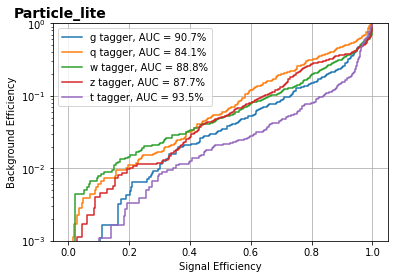

In [18]:
predict_test = model.predict(X_test)
predict_test = predict_test.transpose((1,0))
y_test = y_test.transpose((1,0))
labels = ['g','q','w','z','t']
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[i]
    df[label + '_pred'] = predict_test[i]
    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'Particle_lite',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

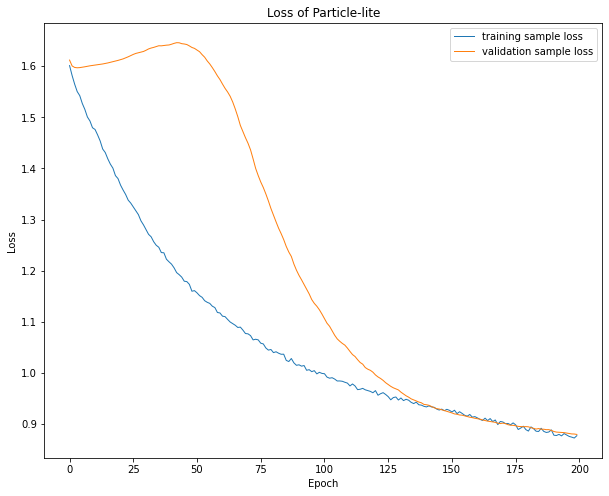

In [19]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()